In [1]:
%pip install lightgbm
%pip install pytorch_tabular
%pip install shap

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
   ---------------------------------------- 0.0/453.1 kB ? eta -:--:--
   ---------------------------- ----------- 317.4/453.1 kB 9.9 MB/s eta 0:00:01
   ---------------------------------------- 453.1/453.1 kB 7.0 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.6 MB ? eta -:--:--
   -------------- ------------------------- 0.9/2.6 MB 19.8 MB/s eta 0:00:01
   --------------------------- ------------ 1.9/2.6 MB 19.6 MB/s eta 0:00:01
   ---------------------------------------  2.6/2.6 MB 21.1 MB/s eta 0:00:01
   ---------------------------------------- 2.6/2.6 MB 15.3 MB/s eta 0:00:00
   ---------------------------------------- 0.0/28.1 MB ? eta -:--:--
    --------------------------------------- 0.5/28.1 MB 16.8 MB/s eta 0:00:02
   - -------------------------------------- 1.4/28.1 MB 14.4 MB/s eta 0:00:02
   --- ---------------------------

In [50]:
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, precision_score, recall_score, f1_score
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import matplotlib.pyplot as plt
import seaborn as sns

# PyTorch Tabular for the neural network
from pytorch_tabular import TabularModel
from pytorch_tabular.config import DataConfig, ModelConfig, OptimizerConfig, TrainerConfig, ExperimentConfig
from pytorch_tabular.models import CategoryEmbeddingModelConfig
import shap

In [51]:
# Load the dataset
data = pd.read_csv('../Dataset/dataset_final.csv')

# Drop unnecessary columns
data = data.drop(['patient_id', 'window_period', 'Sleep_Agitation', 'Physio_Agitation', 'agitation_sleep'], axis=1)
#drop redundant rows
data = data.drop_duplicates()

In [52]:
data.shape

(570, 16)

In [53]:
data[data['Agitation'] == 1].shape[0] / data.shape[0]

0.2912280701754386

In [54]:
# Separate features and target
X = data.drop('Agitation', axis=1)
y = data['Agitation']

# Split the data into train, validation, and test sets with stratification
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)  # Split off the test set
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)  # Split the remainder into validation and test

# Define classifiers
classifiers = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'XGBoost': XGBClassifier(scale_pos_weight=(1 - y.mean()), use_label_encoder=False, eval_metric='logloss'),
    'LightGBM': LGBMClassifier(is_unbalance=True),
    'Extra Trees': ExtraTreesClassifier(n_estimators=100, random_state=42, class_weight='balanced')
}

results_df = pd.DataFrame(columns=['Model Name', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC'])

# Train and evaluate classifiers
for name, clf in classifiers.items():
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    y_proba = clf.predict_proba(X_test)[:, 1] if hasattr(clf, "predict_proba") else None
    result = {
        'Model Name': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1 Score': f1_score(y_test, y_pred),
        'ROC AUC': roc_auc_score(y_test, y_proba) if y_proba is not None else 'N/A'
    }
    result_df = pd.DataFrame([result])
    results_df = pd.concat([results_df, result_df], ignore_index=True)

# Print results in a tabular format
print(results_df.to_string(index=False))

C:\Users\ACER\AppData\Local\Temp\ipykernel_19040\205549767.py:34: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, result_df], ignore_index=True)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 100, number of negative: 242
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000168 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1276
[LightGBM] [Info] Number of data points in the train set: 342, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.292398 -> initscore=-0.883768
[LightGBM] [Info] Start training from score -0.883768
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

In [49]:
X_train

,mean_HR_sleep,HR_var_sleep,mean_RR_sleep,RR_var_sleep,WASO_sleep,SOL_sleep,TIB_sleep,TST_sleep,SE_sleep,snoring_counts_sleep,agitation_sleep,Body Temperature,Diastolic Blood Pressure,Heart Rate,Body weight,Systolic Blood Pressure
366,60.435374,3.820626,14.251701,1.637897,44.0,30.0,596.0,478.0,80.201342,63.0,0.0,36.225,82.0,71.0,83.4,128.0
594,59.418244,4.457726,15.456110,1.527975,73.0,16.0,588.0,390.0,66.326531,29.0,0.0,36.911,91.0,63.0,55.2,152.0
244,67.120815,6.066081,13.410480,1.623553,194.0,24.0,706.0,421.0,59.631728,4.0,0.0,36.579,81.0,67.0,63.4,139.0
495,61.115385,4.292885,15.152015,1.306570,30.0,31.0,558.0,490.0,87.813620,46.0,0.0,36.257,80.0,64.0,91.5,146.0
688,68.314236,4.791682,14.192708,1.733360,46.0,13.0,590.0,515.0,87.288136,37.0,0.0,36.492,74.0,88.0,63.3,140.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151,62.222982,4.252743,12.945280,1.558807,58.0,11.0,733.0,504.0,68.758527,0.0,0.0,36.101,106.0,75.0,62.7,164.0
137,65.056410,3.344092,13.098718,1.945139,83.0,8.0,788.0,682.0,86.548223,0.0,0.0,36.715,108.0,85.0,61.8,166.0
680,63.000000,3.958818,14.547579,1.845357,40.0,33.0,609.0,441.0,72.413793,3.0,0.0,36.724,72.0,86.0,62.9,139.0
333,65.129666,4.015580,18.318271,1.404745,16.0,14.0,516.0,476.0,92.248062,0.0,0.0,36.892,57.0,75.0,69.2,103.0


In [59]:
classifiers['LightGBM'].predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.95      0.97        81
           1       0.89      0.97      0.93        33

    accuracy                           0.96       114
   macro avg       0.94      0.96      0.95       114
weighted avg       0.96      0.96      0.96       114



In [55]:
results_df

,Model Name,Accuracy,Precision,Recall,F1 Score,ROC AUC
0,Random Forest,0.964912,0.891892,1.000000,0.942857,0.977927
1,Gradient Boosting,0.947368,0.864865,0.969697,0.914286,0.981294
2,XGBoost,0.956140,0.888889,0.969697,0.927536,0.981294
3,LightGBM,0.956140,0.888889,0.969697,0.927536,0.980546
4,Extra Trees,0.956140,0.888889,0.969697,0.927536,0.982791


In [56]:
# Define the stratified k-fold cross-validator
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Create an empty DataFrame to store results
k_fold_results_df = pd.DataFrame(columns=['Model', 'Mean F1 Score after 10-fold CV'])

# Iterate over each classifier
for model_name, classifier in classifiers.items():
    # Perform cross-validation
    cv_scores = cross_val_score(classifier, X, y, cv=skf, scoring='f1')
    
    # Store results in the DataFrame
    new_row = pd.DataFrame({
        'Model': [model_name],
        'Mean F1 Score after 10-fold CV': [cv_scores.mean()]
    })
    k_fold_results_df = pd.concat([k_fold_results_df, new_row], ignore_index=True)

# Display the results
print(k_fold_results_df)

C:\Users\ACER\AppData\Local\Temp\ipykernel_19040\3097856505.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  k_fold_results_df = pd.concat([k_fold_results_df, new_row], ignore_index=True)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 150, number of negative: 363
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000381 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1802
[LightGBM] [Info] Number of data points in the train set: 513, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.292398 -> initscore=-0.883768
[LightGBM] [Info] Start training from score -0.883768
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

# SHAP Analysis

C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\shap\explainers\_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


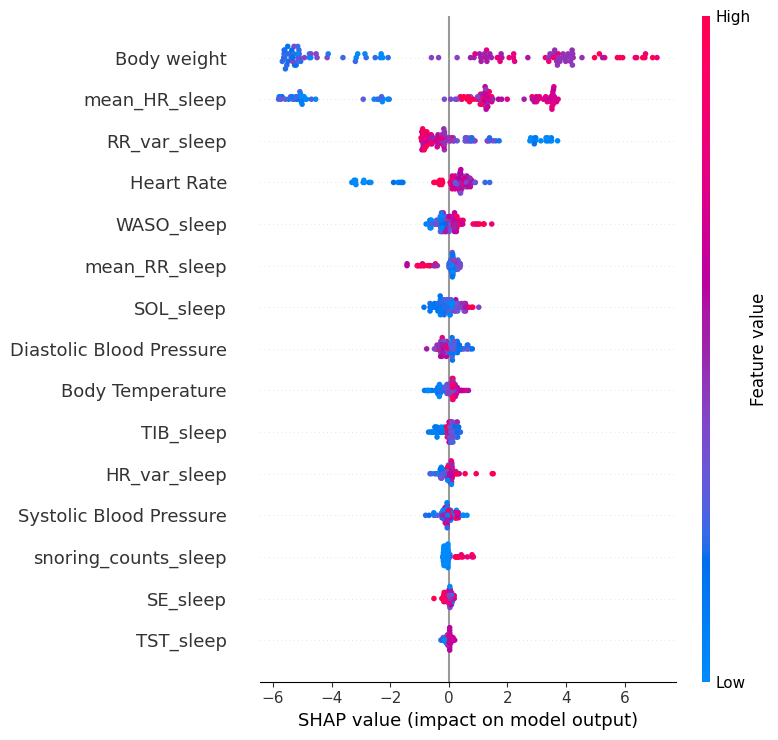

In [60]:
import shap

# Initialize the SHAP Explainer using the tree explainer for tree-based models
explainer = shap.TreeExplainer(classifiers['LightGBM'])

# Calculate SHAP values
shap_values = explainer.shap_values(X_test)

# Summary plot of SHAP values
shap.summary_plot(shap_values, X_test, plot_type="dot")

In [14]:
print("Type of shap_values object:", type(shap_values))
print("Length of shap_values list:", len(shap_values))
print("Shape of SHAP values for class 0:", shap_values[0].shape)
print("Shape of SHAP values for class 1:", shap_values[1].shape)
print("Shape of X_test data:", X_test.shape)

Type of shap_values object: <class 'shap._explanation.Explanation'>
Length of shap_values list: 114
Shape of SHAP values for class 0: (16, 2)
Shape of SHAP values for class 1: (16, 2)
Shape of X_test data: (114, 16)


C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\lightgbm\basic.py:696: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\shap\explainers\_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


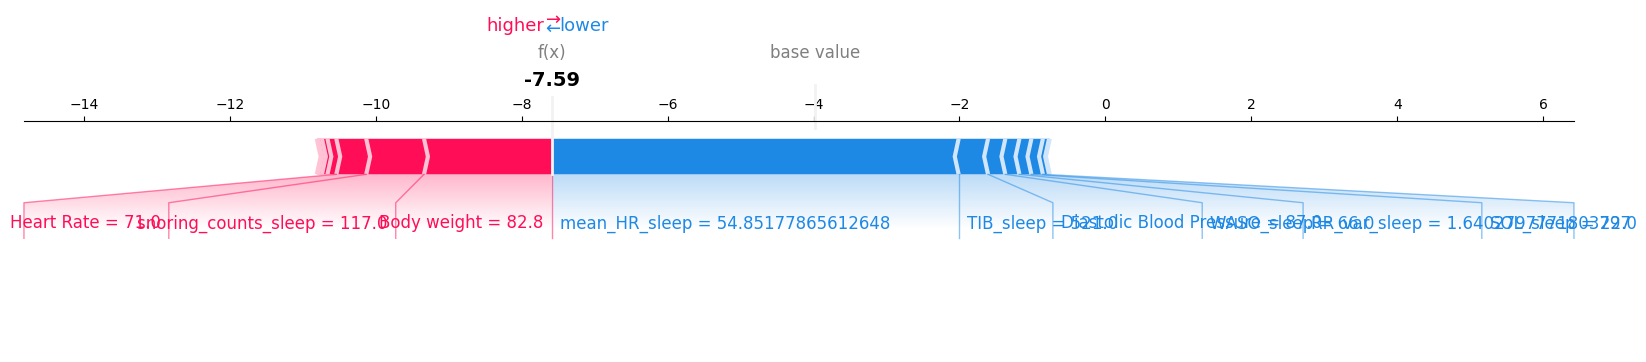

In [62]:
# Select a specific instance (e.g., the first one in the test set)
instance_index = 0  # or any index of interest
single_record = X_test.iloc[instance_index:instance_index+1]

# Calculate SHAP values for the selected instance
shap_values_single = explainer.shap_values(single_record)

# Generate a force plot for the selected instance
shap.force_plot(
    base_value=explainer.expected_value, # the reference value that the features start from
    shap_values=shap_values_single,      # SHAP values for the selected instance
    features=single_record,              # the selected instance's feature values
    matplotlib=True                      # set to True to render it as matplotlib figure
)

C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\lightgbm\basic.py:696: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\shap\explainers\_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


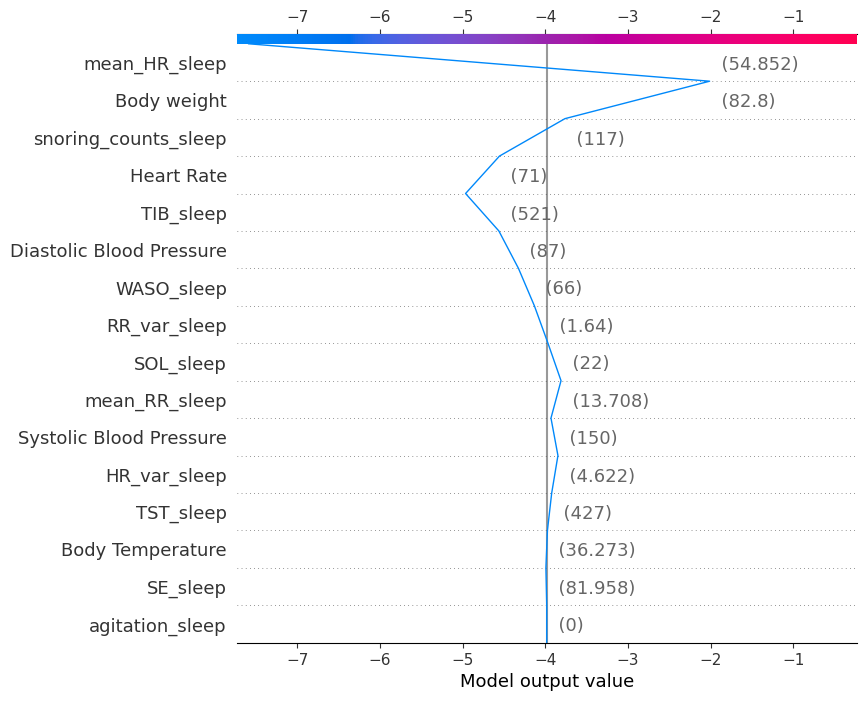

In [40]:
# Calculate SHAP values for the selected instance, if not already calculated
shap_values_single = explainer.shap_values(single_record)

# Make a decision plot for the selected instance
shap.decision_plot(
    base_value=explainer.expected_value,
    shap_values=shap_values_single,
    features=single_record,
    # You may also include feature_names as a parameter if your DataFrame doesn't have column names
    feature_names=X_test.columns.tolist()
)

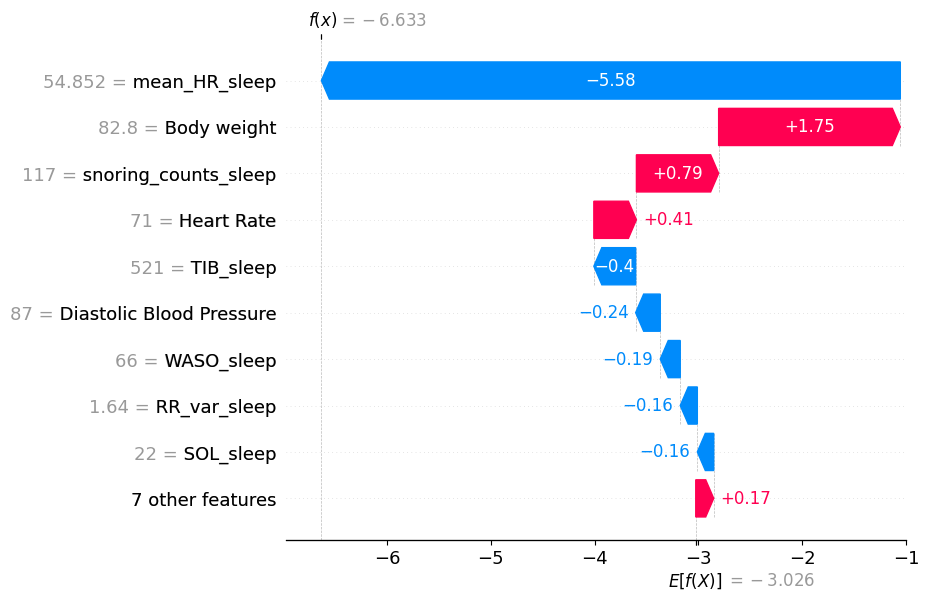

In [47]:
# Generate a waterfall plot for the selected instance
shap.waterfall_plot(
    shap.Explanation(
        values=shap_values_single[0], # Use [0] or [1] for binary classification, depending on the class of interest
        base_values=explainer.expected_value,
        data=single_record.values[0], # Convert to array if necessary
        feature_names=X_test.columns.tolist()
    )
)

# Tabular Neural Network

In [13]:
# Adding a Tabular Neural Network
data_config = DataConfig(
    target=['Agitation'],
    continuous_cols=X_train.columns.tolist(),
    categorical_cols=[],
)

model_config = CategoryEmbeddingModelConfig(
    task="classification",
    layers="512-256-128",
    activation="ReLU",
)

trainer_config = TrainerConfig(
    auto_lr_find=True,
    batch_size=64,
    max_epochs=50,
    gpus=0,
)

tabular_model = TabularModel(
    data_config=data_config,
    model_config=model_config,
    optimizer_config=OptimizerConfig(),
    trainer_config=trainer_config,
    experiment_config=None
)

# Fit the model using training and validation sets
tabular_model.fit(train=X_train, validation=X_val)

TypeError: TrainerConfig.__init__() got an unexpected keyword argument 'gpus'

In [ ]:
# Evaluate on the test set
evaluation = tabular_model.evaluate(X_test)
predictions = tabular_model.predict(X_test)
predictions_proba = tabular_model.predict_proba(X_test)

# Adding results of the Tabular Neural Network
results['Tabular Neural Network'] = {
    'accuracy': accuracy_score(y_test, predictions['prediction']),
    'precision': precision_score(y_test, predictions['prediction']),
    'recall': recall_score(y_test, predictions['prediction']),
    'f1_score': f1_score(y_test, predictions['prediction']),
    'roc_auc': roc_auc_score(y_test, predictions_proba[:, 1])
}
print(f"Tabular Neural Network - Accuracy: {results['Tabular Neural Network']['accuracy']}, ROC AUC: {results['Tabular Neural Network']['roc_auc']}, F1 score: {results['Tabular Neural Network']['f1_score']}, Precision: {results['Tabular Neural Network']['precision']}, Recall: {results['Tabular Neural Network']['recall']}")